# Measuring Campaign ROI

**Main Question: How can we measure and maximize the return on investment (ROI) for personalized marketing efforts?** \
**Objective:** Develop a model that predicts the ROI of different marketing campaigns, incorporating factors like conversion rate, customer lifetime value
(CLV), and acquisition cost.\
**Expected Outcome:** Provide recommendations on which campaign strategies yield the best ROI.

### Table of Contents
1. Problem Analysis
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Acquisition Cost Sub-Model
5. Conversion Rate Sub-Model
6. ROI Model
7. Summary

# 1. Problem Analysis

In the highly competitive banking industry, it is important for banks to maintain their competitiveness by focusing their marketing efforts on campaigns that generate the highest return on investment (ROI). However, banks often struggle to quantify the ROI for different marketing efforts, making it difficult to determine which campaigns generate the highest profitability and long-term customer value. Therefore, being able to measure and predict the ROI of marketing campaigns is crucial for efficient allocation of marketing budgets, ensuring that a bank employs the most effective marketing strategy.

To tackle this challenge, we aim to develop a model that can predict the ROI of various bank marketing campaigns based on key influencing factors such as conversion rate and acquisition cost. Conversion rate and acquisition cost will be estimated using 2 individual models, using campaign-specific features such as campaign type (email marketing, telemarketing, etc), campaign duration, target audience, campaign langauge, and campaign timeframe as inputs. Then, the outputs of these 2 sub-models will be used to develop a model to predict ROI.

# 2. Data Preprocessing

In [2271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# load datasets
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df =  pd.read_csv("../../data/processed/customer.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
engagement_details_df.head(), customer_df.head(), campaigns_df.head()
campaigns_df

,campaign_id,campaign_type,target_audience,campaign_duration,conversion_rate,acquisition_cost,roi,campaign_language,impressions,clicks
0,71,Display Advertising,25-34,75,0.0633,30.39,1.001057,French,6628,420.0
1,34,Display Advertising,45-54,30,0.0406,16.51,1.255072,Mandarin,4616,187.0
2,63,Affiliate Marketing,25-34,60,0.1901,222.24,3.271396,Spanish,41480,7885.0
3,21,Search Engine Optimization,35-44,60,0.1442,156.78,3.662914,English,41514,5986.0
4,48,Display Advertising,25-34,60,0.0600,38.83,1.183959,French,46971,2818.0
...,...,...,...,...,...,...,...,...,...,...
94,33,Affiliate Marketing,45-54,15,0.1591,84.49,3.301523,English,26282,4181.0
95,16,Email Marketing,18-24,30,0.0337,11.31,0.606951,Mandarin,46875,1580.0
96,24,Search Engine Optimization,25-34,15,0.1531,50.36,2.577449,Spanish,33947,5197.0
97,30,Display Advertising,45-54,15,0.0529,32.62,1.289713,German,6296,333.0


In [2272]:
### Obtaining derived variables ###

# Join engagement_details with customer.csv on customer_id, adding CLV column
engagement_details_with_clv = engagement_details_df.merge(
    customer_df[['customer_id', 'customer_lifetime_value']],
    on='customer_id',
    how='left'
)

# Compute the average CLV per campaign
avg_clv_per_campaign = engagement_details_with_clv.groupby('campaign_id', as_index=False)['customer_lifetime_value'].mean()
avg_clv_per_campaign.rename(columns={'customer_lifetime_value': 'avg_clv'}, inplace=True)

# Merge campaigns.csv with avg_clv_per_campaign on campaign_id
merged_campaigns = campaigns_df.merge(avg_clv_per_campaign, on='campaign_id', how='left')

# Select and rearrange the required columns
df = merged_campaigns[['campaign_id', 'campaign_type', 'target_audience', 'campaign_duration',
                       'campaign_language', 'conversion_rate', 'acquisition_cost', 'avg_clv', 'roi']]
df

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
0,71,Display Advertising,25-34,75,French,0.0633,30.39,728.518344,1.001057
1,34,Display Advertising,45-54,30,Mandarin,0.0406,16.51,752.844152,1.255072
2,63,Affiliate Marketing,25-34,60,Spanish,0.1901,222.24,719.763148,3.271396
3,21,Search Engine Optimization,35-44,60,English,0.1442,156.78,742.841625,3.662914
4,48,Display Advertising,25-34,60,French,0.0600,38.83,747.176181,1.183959
...,...,...,...,...,...,...,...,...,...
94,33,Affiliate Marketing,45-54,15,English,0.1591,84.49,754.491278,3.301523
95,16,Email Marketing,18-24,30,Mandarin,0.0337,11.31,750.862278,0.606951
96,24,Search Engine Optimization,25-34,15,Spanish,0.1531,50.36,742.031446,2.577449
97,30,Display Advertising,45-54,15,German,0.0529,32.62,743.055399,1.289713


# 3. Exploratory Data Analysis (EDA)

##### Summary Statistics

In [2273]:
# Summary statistics and pairplot to explore relationships
summary_stats = df.describe(include='all')
summary_stats

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
count,99.000000,99,99,99.000000,99,99.000000,99.000000,99.000000,99.000000
unique,NaN,5,5,NaN,5,NaN,NaN,NaN,NaN
top,NaN,Display Advertising,25-34,NaN,German,NaN,NaN,NaN,NaN
freq,NaN,32,32,NaN,29,NaN,NaN,NaN,NaN
mean,50.000000,NaN,NaN,39.545455,NaN,0.091936,73.782424,734.303477,1.874160
std,28.722813,NaN,NaN,20.825942,NaN,0.049843,68.117015,23.750505,0.964573
min,1.000000,NaN,NaN,15.000000,NaN,0.009400,1.860000,681.818278,0.501734
25%,25.500000,NaN,NaN,15.000000,NaN,0.053700,22.570000,718.105437,1.121429
50%,50.000000,NaN,NaN,30.000000,NaN,0.080000,49.270000,733.044583,1.645739
75%,74.500000,NaN,NaN,60.000000,NaN,0.131350,108.250000,750.753159,2.575624


In [ ]:
# Log-transform the acquisition_cost column due to high variance
df['log_acquisition_cost'] = np.log(df.acquisition_cost)
# Encode an order for target_audience
df['target_audience'] = pd.Categorical(df.target_audience, ordered=True)

##### Campaign-related features vs Acquisition Cost, Conversion Rate, CLV
First, let's explore the relationships between the campaign-related features and CLV, acquisition cost, conversion rate and respectively. These insights may drive our decisions regarding feature and model selection.

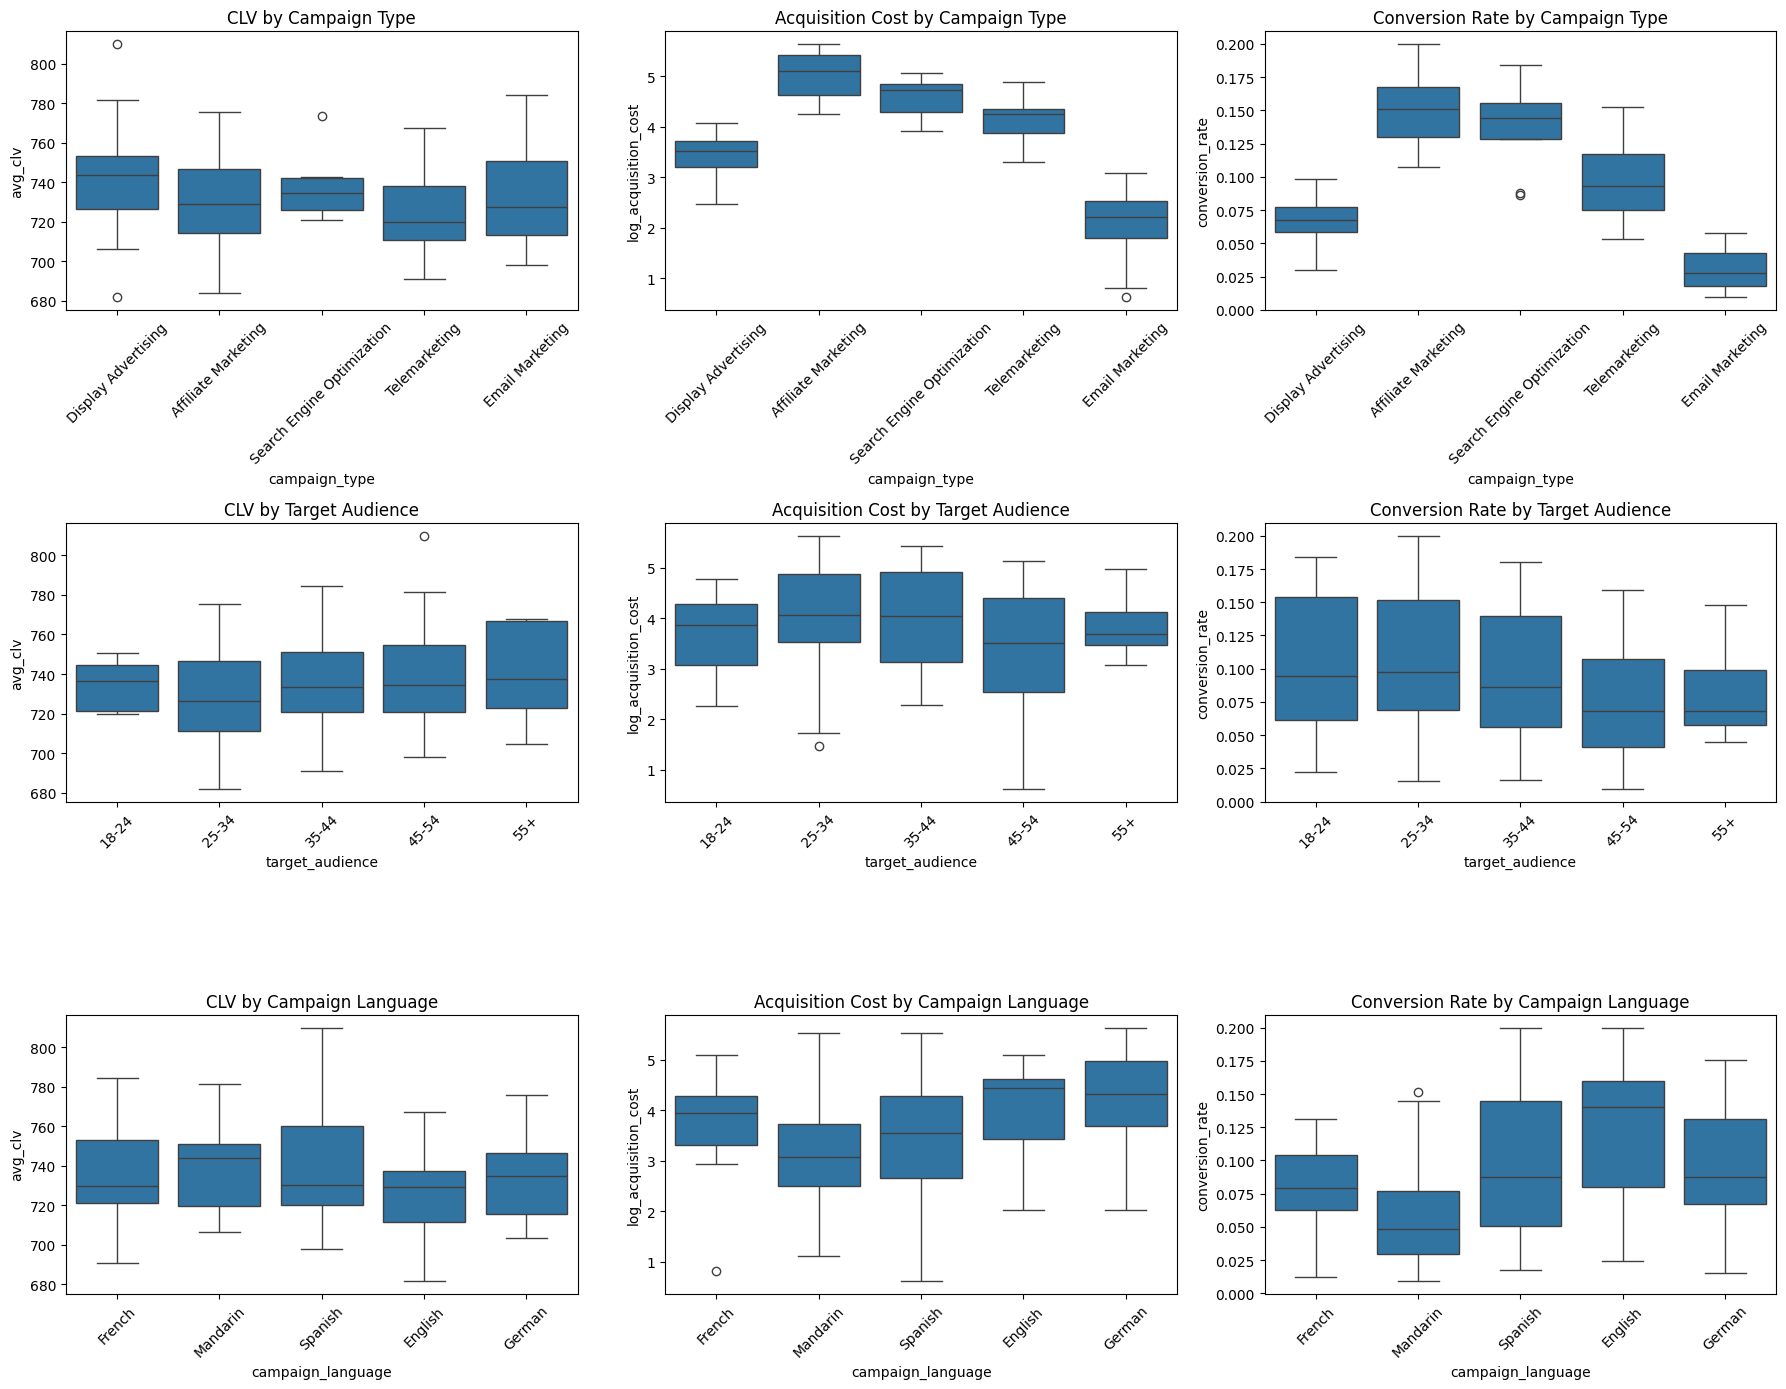

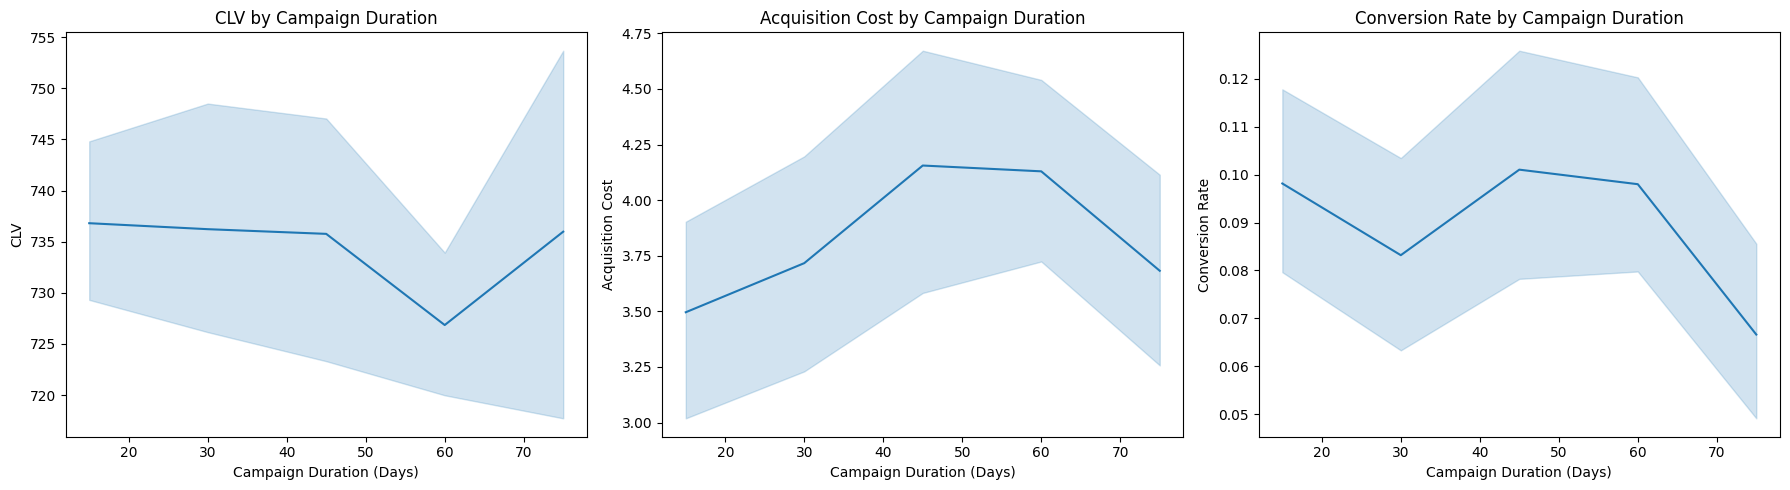

In [2275]:
# Configure grid for categorical feature vs CLV, Cost, Conversion Rate
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
categorical_vars = ['campaign_type', 'target_audience', 'campaign_language']
numerical_targets = ['avg_clv', 'log_acquisition_cost', 'conversion_rate']
titles = ['CLV', 'Acquisition Cost', 'Conversion Rate']

# Plot boxplots for categorical features
for i, cat in enumerate(categorical_vars):
    for j, num in enumerate(numerical_targets):
        sns.boxplot(data=df, x=cat, y=num, ax=axes[i, j])
        axes[i, j].set_title(f'{titles[j]} by {cat.replace("_", " ").title()}')
        axes[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot lineplots for campaign_duration vs each numerical target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for j, num in enumerate(numerical_targets):
    sns.lineplot(data=df, x="campaign_duration", y=num, ax=axes[j])
    axes[j].set_title(f'{titles[j]} by Campaign Duration')
    axes[j].set_xlabel("Campaign Duration (Days)")
    axes[j].set_ylabel(titles[j])

plt.tight_layout()
plt.show()

**Customer Lifetime Value (CLV):**
- Campaign-related features do not significantly differentiate CLV, indicating it is not campaign-specific
- CLV has a relatively small range (680-810)

Hence, we shall omit CLV from our analysis, as it cannot be differentiated across various camapaigns. If necessary, we may consider using its mean in the computation of ROI.

**Acquisition Cost Sub-Model:** \
*Campaign Type:*
- Highest to lowest cost: Affiliate Marketing > SEO > Telemarketing > Display Advertising > Email Marketing
- Strong differentiating factor

*Target Audience:*
- Median acquisition cost is relatively consistent across target audience groups
- Dropped due to low differentiating power

*Campaign Language:*
- Cost decreases from English → German → French → Spanish → Mandarin
- May consider dropping later

*Campaign Duration*
- Slight positive trend between campaign duration and acquisition cost, which could arise from the need for more resources

For the acquisition cost model, we will implement a Linear Regression model on the features `campaign_type`, `campaign_language` and `campaign_duration`. A Linear Regression model was chosen due to its high interpretability, simplicity, and its optimal performance through trial and error with other models.


**Conversion Rate Sub-Model:** \
*Campaign Type:*
- Highest to lowest conversion: Affiliate Marketing > SEO > Telemarketing > Display Advertising > Email Marketing
- Strong differentiating factor

*Target Audience:*
- Conversion rate generally decreases with increased target audience

*Campaign Language:*
- Minimal influence on conversion rate, hence dropped

*Campaign Duration* 
- Minimal influence on conversion rate, hence dropped

For the conversion model, we will implement a Linear Regression model on the features `campaign_type` and `target_audience`. A Linear Regression model was also chosen based on similar reasons as stated above.

# 4. Acquisition Cost Sub-Model

After testing out a few models, a simple Linear Regression model seemed to perform the best. We evaluated the model performance using metrics such as MSE, PMSE, R^2 and adjusted R^2. Then, we extracted the coefficients to analyse the contribution of each variable to the model prediction.

In [ ]:
def cost_model(X, y, categorical_features, numerical_features):
    """
    Trains a linear regression model to predict cost
    Assumes that the target variable y is in log scale (e.g., log(cost)), and returns predictions
    transformed back to the original scale

    Parameters:
    - X: pd.DataFrame, feature matrix containing both categorical and numerical columns
    - y: pd.Series or np.ndarray, target variable (log(cost))
    - categorical_features: list of str, names of categorical columns in X
    - numerical_features: list of str, names of numerical columns in X

    Returns:
    - linreg_model: trained sklearn Pipeline with preprocessing and regression
    - preds: np.ndarray, predicted cost values in original scale (after exp transform)
    - true_vals: np.ndarray, actual cost values in original scale (after exp transform)
    - coef_df: pd.DataFrame, table of model coefficients showing:
        - Feature names
        - Log-scale coefficients
        - Approximate % change in cost for a one-unit increase in each feature
    """
    # Define preprocessor
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

    # Define pipeline
    linreg_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # 5-fold cross-validation due to small dataset size
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Fit model
    linreg_model.fit(X, y)

    # Predict (log scale → original scale)
    log_preds = cross_val_predict(linreg_model, X, y, cv=kf)
    preds = np.expm1(log_preds)
    true_vals = np.expm1(y)

    # Coefficient interpretation
    feature_names = linreg_model.named_steps['preprocessor'].get_feature_names_out()
    log_coefficients = linreg_model.named_steps['regressor'].coef_
    percent_impact = (np.exp(log_coefficients) - 1) * 100

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Log Coefficient': log_coefficients,
        'Approx % Change in Cost': percent_impact
    }).sort_values(by='Approx % Change in Cost', ascending=False)

    return linreg_model, preds, true_vals, coef_df


In [2290]:
# function to evaluate model performance
def evaluate_model_performance(preds, true_vals, num_features):
    """
    Evaluates regression model performance using common metrics: 
    MSE, RMSE, R², and Adjusted R².

    Parameters:
    - preds: array-like, predicted values from the model (e.g., predicted cost or ROI)
    - true_vals: array-like, actual values (must be same length as preds)
    - num_features: int, number of features used in the model (for Adjusted R² calculation)

    Returns:
    - dict: a dictionary containing the following metrics:
        - "MSE": Mean Squared Error
        - "RMSE": Root Mean Squared Error
        - "R2": R-squared
        - "Adjusted R2": Adjusted R-squared

    Prints the evaluation metrics with appropriate formatting.
    """
    n = len(true_vals)
    mse = mean_squared_error(true_vals, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_vals, preds)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - num_features - 1)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adj_r2
    }

In [2291]:
# Run cost model on the selected features
X = df[['campaign_type', 'campaign_duration', 'campaign_language']]
y = df['log_acquisition_cost']
cat_feats = ['campaign_type', 'campaign_language']
num_feats = ['campaign_duration']

model, preds_cost, true_vals, coef_df = cost_model(X, y, cat_feats, num_feats)
coef_df

,Feature,Log Coefficient,Approx % Change in Cost
5,cat__campaign_language_German,0.320935,37.841664
6,cat__campaign_language_Mandarin,0.251667,28.616736
4,cat__campaign_language_French,0.172490,18.825984
8,num__campaign_duration,0.010990,1.105090
7,cat__campaign_language_Spanish,-0.171264,-15.740110
2,cat__campaign_type_Search Engine Optimization,-0.400823,-33.023161
3,cat__campaign_type_Telemarketing,-0.999761,-63.203244
0,cat__campaign_type_Display Advertising,-1.701139,-81.752440
1,cat__campaign_type_Email Marketing,-2.974848,-94.894481


In [2292]:
# Evaluate cost_model
metrics = evaluate_model_performance(preds_cost, true_vals, num_features=coef_df.shape[0])
metrics

{'MSE': 669.4354362306166,
 'RMSE': 25.873450412162207,
 'R2': 0.8542506596780199,
 'Adjusted R2': 0.8395119623420894}

**Model Performance** \
The model has an R^2 value of 0.85, suggesting that the model explains about 85% of the variance in the data. Given that acquisition cost not only lies on price predictions but also the success of the campaign, the model performs well and is generally reliable.

The model also produces predictions that deviate about $26 (RMSE) away from their actual values, so the model is able to make good predictions even if trained on a different dataset.

**Relationships between Features** \
Campaigns in `German` and `Mandarin` are more expensive, costing about 37% and 28% more than `English` campaigns respectively. This could stem from the need for specialised localization and media targeting in regions where the Portugese bank has limited presence, and limited in-house language resources. In contrast, `Spanish` campaigns are cheaper by 16%. This may be due to a higher volume of Spanish speakers in Portugal, due to the geographical proximity of Portugal and Spain, and linguistic similarity with Portugese. Therefore, the in-house team in the Portugese bank may already have partial fluency or localization capability in Spanish, reducing the need to engage pricey external vendors. Hence, the Portugese bank should prioritize `English` and `Spanish` campaigns to optimize ROI, and limit high-cost language campaigns like `German` or `Mandarin` unless justified by strong conversion potential.

`Email Marketing` and `Display Advertisting` incurs the lowest cost when compared to `Affiliate Marketing`, reducing cost by 94% and 86% respectively. Hence, for banks that are aiming to cut costs, they could focus more on email marketing campaigns and display advertising, as these channels are easily scalable to a larger audience base without incurring significant additional costs. 

`campaign_duration` only slightly impacts `acquisition_cost`, with longer campaigns associated with an approximate 1% increase. This is likely due to the need for more resources such as manpower, ad space, and continuous tracking of campaign value. However, it is a less significant factor than campaign type, and should not be prioritised as a lever for cost control.

Despite our insights gained on reducing marketing expenditure, we still need to synthesize these insights with the analysis on the value generated from different camapigns to gain a more holistic view of how different campaign types impact ROI.

# 5. Conversion Rate Sub-Model

Similarly, a simple Linear Regression model had the highest performance after experimenting with various models.

In [ ]:
def conversion_model(X, y, categorical_features):
    
    """
    Trains a linear regression model to predict conversion rates using only categorical features.
    One-hot encoding is applied to categorical variables. Cross-validated predictions are used
    to evaluate model performance, and the learned coefficients are returned for interpretation.

    Parameters:
    - X: pd.DataFrame, feature matrix containing categorical columns
    - y: pd.Series or np.ndarray, target variable (conversion rate)
    - categorical_features: list of str, names of categorical columns in X

    Returns:
    - model: trained sklearn Pipeline with preprocessing and regression
    - preds: np.ndarray, predicted conversion rates using 5-fold cross-validation
    - y: np.ndarray or pd.Series, actual conversion rates (same as input `y`)
    - coef_df: pd.DataFrame, table showing:
        - Feature names (from one-hot encoded categories)
        - Corresponding linear regression coefficients (sorted by absolute value)
    """

    # Preprocessor (one-hot encoding for categorical features)
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

    # Pipeline with linear regression
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Fit and predict using cross_val_predict
    model.fit(X, y)
    preds = cross_val_predict(model, X, y, cv=kf)

    # Coefficient extraction
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    coefficients = model.named_steps['regressor'].coef_
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    return model, preds, y, coef_df

In [2281]:
# Run conversion rate model on the selected features
X_conv = df[['campaign_type', 'target_audience']]
y_conv = df['conversion_rate']
cat_features_conv = ['campaign_type', 'target_audience']

model_conv, preds_conv, true_conv, coef_df_conv = conversion_model(X_conv, y_conv, cat_features_conv)
coef_df_conv

,Feature,Coefficient
1,cat__campaign_type_Email Marketing,-0.119868
0,cat__campaign_type_Display Advertising,-0.083835
3,cat__campaign_type_Telemarketing,-0.051856
7,cat__target_audience_55+,-0.041985
6,cat__target_audience_45-54,-0.032193
2,cat__campaign_type_Search Engine Optimization,-0.016273
5,cat__target_audience_35-44,-0.015337
4,cat__target_audience_25-34,-0.010513


In [2294]:
# Evaluate conversion rate model
metrics_conv = evaluate_model_performance(preds_conv, true_conv, num_features=coef_df_conv.shape[0])
metrics_conv

{'MSE': 0.00044869754713209345,
 'RMSE': 0.021182482081476984,
 'R2': 0.8175487800726033,
 'Adjusted R2': 0.8013308938568348}

**Model Performance** \
The model has an R^2 value of 0.82, suggesting that the model explains about 73% of the variance in the data. Given the relatively high R^2 value and low RMSE (2.1%), the model generally has a good predictive ability and is stable.

**Relationships between Features** \
`Affiliate Marketing` yields the highest conversion rates, followed by `SEO`, `Telemarketing`, `Display Advertising`, and `Email Marketing`. This aligns with model coefficients—for example, `Email Marketing` has a lower `conversion_rate` of ~11.9 percentage points, while `SEO` has a lower `conversion_rate` of ~1.6 points relative to `Affiliate Marketing`. This may be because affiliate campaigns—often driven by influencers—offer a more personalized and relatable experience that builds trust. In contrast, email marketing tends to be less targeting and often gets filtered out by spam detection systems. Banks should consider allocating more resources to Affiliate and SEO campaigns while re-evaluating their email marketing strategy. Recommendations include avoiding spam-triggering keywords and crafting more personalized, targeted email content to improve reach and engagement.

Generally, campaigns targeted at older age groups have lower conversion rates. Compared to potential customers aged `18-24`, targeting the `45–54` and `55+` segments results in lower conversion rates, reduced by ~3.2 and ~4.1 percentage points respectively. This may be due to lower digital engagement or a preference for in-person banking among older customers. Banks should consider prioritizing younger segments for digital campaigns, while exploring alternative channels or messaging strategies to better engage older audiences.

Once again, these insights should be synthesized with those from other models to generate more holistic reccommendations.

# 6. ROI Model

Exploring the distributions of conversion rate and acquisition cost may give us some idea of their relationship with ROI. From the graphs below, it seems that ROI may be modelled using a Linear Regression model.

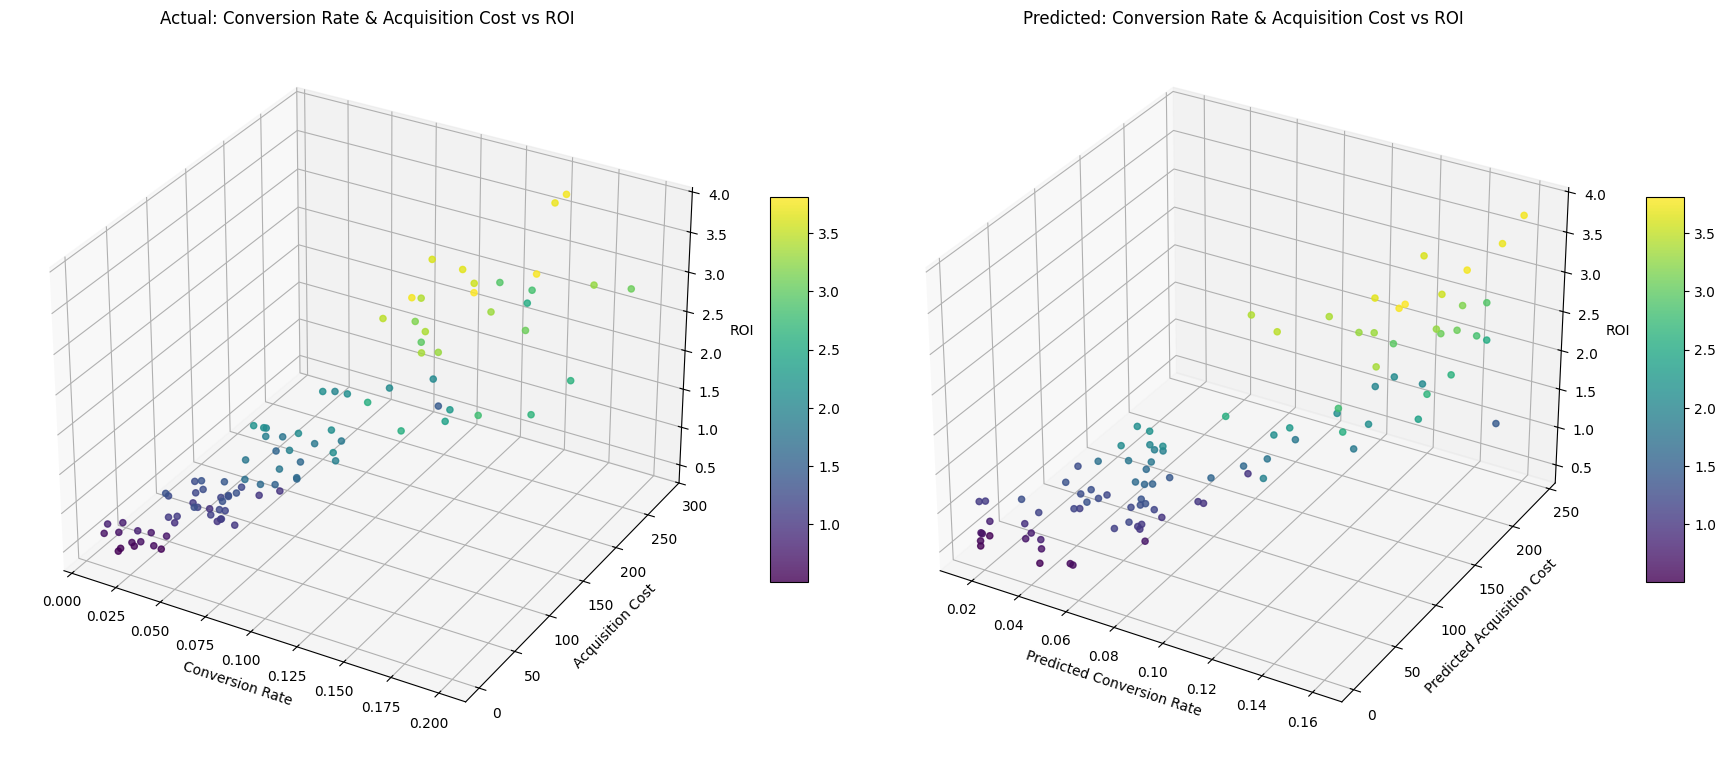

In [2283]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 8))

# Actual conversion rate & acquisition cost vs ROI
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(df['conversion_rate'], df['acquisition_cost'], df['roi'],
                  c=df['roi'], cmap='viridis', alpha=0.8)
ax1.set_xlabel("Conversion Rate")
ax1.set_ylabel("Acquisition Cost")
ax1.set_zlabel("ROI")
ax1.set_title("Actual: Conversion Rate & Acquisition Cost vs ROI")
fig.colorbar(sc1, ax=ax1, shrink=0.5, aspect=10)

# Predicted conversion rate & acquisition cost vs ROI
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(preds_conv, preds_cost, df['roi'],
                  c=df['roi'], cmap='viridis', alpha=0.8)
ax2.set_xlabel("Predicted Conversion Rate")
ax2.set_ylabel("Predicted Acquisition Cost")
ax2.set_zlabel("ROI")
ax2.set_title("Predicted: Conversion Rate & Acquisition Cost vs ROI")
fig.colorbar(sc2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

In [2286]:
def predict_roi(preds_conv, preds_cost, y_roi):
    """
    Train a Linear Regression model using standardized predicted conversion and cost values.

    Parameters:
    - preds_conv: predicted conversion rates
    - preds_cost: predicted costs
    - y_roi: actual ROI values

    Returns:
    - model: trained LinearRegression instance
    - X_roi_scaled: standardized input matrix used for prediction
    - scaler: fitted StandardScaler instance (for inverse transforms if needed)
    """
    X_roi = np.column_stack([preds_conv, preds_cost])
    
    # Standardize features
    scaler = StandardScaler()
    X_roi_scaled = scaler.fit_transform(X_roi)
    
    # Train model
    model = LinearRegression()
    model.fit(X_roi_scaled, y_roi)
    
    return model, X_roi_scaled, scaler

model, X_roi_scaled, scaler = predict_roi(preds_conv, preds_cost, df['roi'])

coefficients = model.coef_
feature_names = ['Conversion Rate', 'Cost']

for name, coef in zip(feature_names, coefficients):
    print(f"{name} coefficient: {coef:.4f}")


print("Conversion rate coefficient:", coefficients[0])
print("Cost coefficient:", coefficients[1])

def evaluate_roi_model(preds_conv, preds_cost, y_roi):
    """
    Evaluates a Linear Regression model using 3-fold CV

    Parameters:
    - preds_conv: predicted conversion rates (ouput of conversion_model)
    - preds_cost: predicted costs (ouput of cost_model)
    - y_roi: actual ROI values

    Returns:
    - mean_r2_roi: mean R² score from 3-fold CV
    - mean_mse: mean MSE from 3-fold CV
    - mean_rmse: mean RMSE from 3-fold CV
    """
    X_roi = np.column_stack([preds_conv, preds_cost])
    model = LinearRegression()
    
    # R² scores
    cv_scores_r2 = cross_val_score(model, X_roi, y_roi, cv=3, scoring='r2')
    mean_r2_roi = np.mean(cv_scores_r2)

    # Predictions for MSE and RMSE
    preds = cross_val_predict(model, X_roi, y_roi, cv=3)
    mean_mse = mean_squared_error(y_roi, preds)
    mean_rmse = np.sqrt(mean_mse)

    return mean_r2_roi, mean_mse, mean_rmse

mean_r2_roi, mean_mse, mean_rmse = evaluate_roi_model(preds_conv, preds_cost, df['roi'])
print(f"Mean R²: {mean_r2_roi:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")

Conversion Rate coefficient: 0.8620
Cost coefficient: -0.0530
Conversion rate coefficient: 0.8619922429536171
Cost coefficient: -0.052998023477880005
Mean R²: 0.6983
Mean MSE: 0.2785
Mean RMSE: 0.5277


**Model Performance** \
The model explains about 70% (R^2 = 0.69) of the variance in ROI, indicating a strong relationship between the predicted camapign cost and conversion rates with ROI. 

**Relationship of conversion rate and acquisition cost with ROI** \
The strong positive coeffiecient of 0.86 for conversion rate suggests that an increase in conversion rate has a sigificantly positive impact on ROI. On the contrary, the small negative coefficient of -0.053 for cost implies that cost has a slightly negative effect on ROI, which aligns with our intuitive beliefs. 

Therefore, while minimising campaign cost is important, conversion rate influences ROI a lot more, and should be prioritised when trying to maximise ROI.

# 7. Summary

**Main Question: How can we measure and maximize the return on investment (ROI) for personalized marketing efforts?** \
We have developed a predictive ROI model, that depends on 2 sub-models that predict acquisition cost and conversion rate. Conversion rate is the key driver of ROI, while cost plays a smaller, negative role. Using this, we can identify and rank key strategies to boost ROI.

**Key Recommendations:**
1. Focus on increasing conversion rate
- Prioritise efforts that increase conversion (listed below), even if slightly higher costs are incurred

To increase conversion rate...

2. Invest in Affiliate Marketing and SEO, and re-evaluate lower-performing ones
- Affiliate Marketing drives the highest conversions, as these campaigns are more relatable and personal
- SEO also drives higher conversions, as it results in organic traffic

3. Target younger audiences
- Focus digital marketing efforts on younger customers
- Use more traditional channels for older groups

To reduce acqusition cost...

4. Re-evaluate Email and Display Ads Marketing Strategy
- While Email and Display Ads are cost-effective, they may drive lower conversions
- Email Marketing could be further improved by re-evaluating email content (avoid spam-detection keywords, weak call-to-actions, impersonal messages)
- Display Ads should be more eye-catching, include call-to-actions, and configured across different device platforms
- After improving the engagement of Email and Display Ad marketing, the bank can increase the volume of such campaigns at minimal costs
